# LINMA2472 - Group15's project : analysis of our musical tastes and further predictions

# Part 2 : Analysis of the lyrics

Created on Dec 2020 \\
@authors : Juliette Glorieux, Tom Kenda & Colin Scherpereel \\
LINMA2472 - Algorithms in data science \\
Academic year : 2020 - 2021 \\

# Textual analysis with lyrics

In [ ]:
from tqdm.notebook import tqdm   # progress bar
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Pre-processing step

### Getting the songs

Import CSV files that were manually created for each user.

In [ ]:
T_path = "Lyrics_tom.txt"
J_path = "Lyrics_juliette.txt"
C_path = "Lyrics_colin.txt"
test_path = "test_set.txt"

In [ ]:
# Tom's music
with open(T_path, "r", encoding = "utf-8") as fp:
    text = fp.read()
    all_songs_T = text.split("\n\n\n")                            # each music = 1line
    for c in ["\n", "[Orelsan:]", "[Gringe:]", "  "] :            #char to remove
      all_songs_T = [song.replace(c," ") for song in all_songs_T]

print(len(all_songs_T))
all_songs_T

# Ju's music
with open(J_path, "r", encoding="UTF-8") as fp:
    text = fp.read()
    all_songs_J = text.split("\n\n\n")                     # each music = 1line
    for c in ["\n", "  "] :                                #char to remove
      all_songs_J = [song.replace(c," ") for song in all_songs_J]

print(len(all_songs_J))
all_songs_J

# Colin's music
with open(C_path, "r", encoding="UTF-8") as fp:
    text = fp.read()
    all_songs_C = text.split("\n\n\n")                     # each music = 1line
    for c in ["\n", "  "] :                                #char to remove
      all_songs_C = [song.replace(c," ") for song in all_songs_C]

print(len(all_songs_C))

# test music
with open(test_path, "r", encoding="UTF-8") as fp:
    text = fp.read()
    test_songs = text.split("\n\n\n")                     # each music = 1line
    for c in ["\n", "  "] :                                #char to remove
      test_songs = [song.replace(c," ") for song in test_songs]

print(len(test_songs))

35
29
35
10


In [ ]:
print(test_songs)

['À chaque album, une fille qui va, l\'premier cri avant la révolte Simple comme un cœur qui bat, j\'suis la grêle avant la récolte Ma dernière chance au bar-tabac, on pleure comme des saxophones Ils traînent ensemble quand t\'es pas là Rejoins nous, on part sans eux Dans le noir, t\'es ma lanterne à la lumière, t\'es mal en point Fais la photo, fais la photo, école, accord parental Part en tournée comme en guerre, main d\'argent et masque en fer Peinture fraîche masque misère, tout perdre au test salivaire Certifié grâce à Deezer tu m\'as dit "c\'est facile à faire" Tu l\'as pas fait, c\'est bizarre, j\'reste à Rennes mais y a rien à faire Est-ce que je peux sampler vos pleurs? Si tu t\'en vas, j\'suis solitaire Raconte ta vie au répondeur, j\'te jure qu\'t\'auras plus jamais peur J\'m\'endors sur la mélodie que joue ta corde sensible J\'ai joui mais j\'en veux encore J\'m\'envole, c\'est la gloire ou l\'asile Tu sais tout n\'est pas si facile quand le courant t\'emporte J\'m\'endors 

### Cleanning the songs

To implement the embedder, we have to provide it clean sentences. We remove weird punctuations using the following function and apply it to all the sentences sets.

In [ ]:
import string
def delete_punctuation(sent):
  ''' Remove the weird punctuation, 
  @input : one sentence (one element of the list with all the sentence)
  @output : a copy of this sentence that has been cleaned up
  '''
  sent = sent.replace('"', "")  # Weird character 1
  sent = sent.replace("“", "")  # Weird character 2
  sent = sent.replace("”", " ")
  sent = sent.replace("\n", " ") # Weird character 3
  sent = sent.replace("\'", "'") # Weird character 4
  sent = sent.replace("(","")
  sent = sent.replace(")","")
  return sent 
  
s = 'Lunettes sur le nez, j\'essaye de passer incognito Sur le B, j\'vesqui qui les condés'
print(delete_punctuation(s))

Lunettes sur le nez, j'essaye de passer incognito Sur le B, j'vesqui qui les condés


In [ ]:
def clean_sentence(all_sentences) :
  ''' Clean the sentences in a list of sentences
  @input : a list of sentences
  @output : a copy of this list with all the sentences that have been cleaned up
  '''
  all_sentences_clean = []
  for sent in all_sentences:            # for all sentence in the text
    sent_clean = delete_punctuation(sent)     # remove weird punct.
    all_sentences_clean.append(sent_clean)
  return all_sentences_clean

print(clean_sentence([s,s]))

["Lunettes sur le nez, j'essaye de passer incognito Sur le B, j'vesqui qui les condés", "Lunettes sur le nez, j'essaye de passer incognito Sur le B, j'vesqui qui les condés"]


In [ ]:
clean_song_J = clean_sentence(all_songs_J)
clean_song_C = clean_sentence(all_songs_C)
clean_song_T = clean_sentence(all_songs_T)
clean_song_T[-1].split()[:3]

['Moi,', "j'vends", 'pas']

Now that they are clean. There are a few other things that can be done to make the task of embedding more easy and efficient for the coputer. They are describe here : https://www.stat4decision.com/fr/traitement-langage-naturel-francais-tal-nlp/ with exemple for french text.

### Prepocessing with spacy

This removes useless word for the context.

In [ ]:
# installation of spacy
!pip install spacy
# downloading french package
!python -m spacy download fr_core_news_sm

     |████████████████████████████████| 14.7MB 804kB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-cp36-none-any.whl size=14727027 sha256=0b3168a06c4592dbafb83078f2b828e108504ef6d46b840c5b51ecba9794b23d
  Stored in directory: /tmp/pip-ephem-wheel-cache-07tf4dom/wheels/46/1b/e6/29b020e3f9420a24c3f463343afe5136aaaf955dbc9e46dfc5
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [ ]:
# !pip install deplacy
import pkg_resources,imp
imp.reload(pkg_resources)
import spacy
nlp=spacy.load("fr_core_news_sm")
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='french')

doc=nlp("L'essentiel est invisible pour les yeux.")
# import deplacy
# deplacy.render(doc)
# deplacy.serve(doc,port=None)
# # import graphviz
# # graphviz.Source(deplacy.dot(doc))

In [ ]:
test = "C'est pas le quartier qui me quitte! c'est moi j'quitte le quartier... Eeeet la moulaga ?"

**Removing stop words & stemming**

In [ ]:
# importing french stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords = set(stopwords.words('french'))
print(stopWords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'eussiez', 'fûmes', 'ayantes', 'du', 'm', 'étions', 'elle', 'qu', 'auriez', 'ou', 'et', 'seriez', 'fûtes', 'notre', 'toi', 'eussent', 'seras', 'soient', 'son', 'ont', 'ce', 't', 'aurais', 'sa', 's', 'sera', 'aurait', 'ton', 'étais', 'aies', 'd', 'soyons', 'serait', 'serons', 'étant', 'aie', 'fussions', 'je', 'aurai', 'avait', 'avons', 'nos', 'avais', 'fus', 'avaient', 'soit', 'n', 'étiez', 'vos', 'fut', 'furent', 'dans', 'leur', 'ne', 'ma', 'ai', 'qui', 'j', 'était', 'eurent', 'aux', 'serais', 'sur', 'les', 'est', 'pas', 'eûtes', 'fût', 'ayants', 'sommes', 'eue', 'étante', 'ayons', 'eûmes', 'tu', 'votre', 'seraient', 'se', 'avions', 'aviez', 'auras', 'étés', 'auront', 'suis', 'moi', 'ces', 'eussions', 'tes', 'mon', 'me', 'lui', 'fusses', 'aurez', 'ils', 'étée', 'eût', 'serez', 'es', 'étaient', 'une', 'étées', 'eues', 'êtes', 'avec', 'eus', 'serai', 'on', 'c', 'nous', 'ta', 'v

Before doing this we need to be abble to separated token

In [ ]:
def word_tokenize(sentence):
    # Tokeniser la phrase
    doc = nlp(sentence)
    # Retourner le texte de chaque token
    return [X.text for X in doc]

In [ ]:
def word_stem(sentence):
    doc = nlp(sentence)
    return [stemmer.stem(X.text) for X in doc]

print(test)
' '.join(w for w in word_stem(test))

C'est pas le quartier qui me quitte! c'est moi j'quitte le quartier... Eeeet la moulaga ?


"c' est pas le quarti qui me quitt ! c' est moi j' quitt le quarti ... eeeet la moulag ?"

In [ ]:
def cleanner(song_list):
  clean_song_list = []
  for song in song_list:
    clean_song = ' '.join(w for w in word_tokenize(song) if w not in stopWords)
    clean_song = ' '.join(w for w in word_stem(clean_song))
    clean_song_list.append(clean_song)

  return clean_song_list

print(test)
print(cleanner([test,test]))


C'est pas le quartier qui me quitte! c'est moi j'quitte le quartier... Eeeet la moulaga ?
["c ' quarti quitt ! c ' j ' quitt quarti ... eeeet moulag ?", "c ' quarti quitt ! c ' j ' quitt quarti ... eeeet moulag ?"]


In [ ]:
clean_song_J2 = cleanner(clean_song_J)
clean_song_C2 = cleanner(clean_song_C)
clean_song_T2 = cleanner(clean_song_T)

In [ ]:
print("Raw lyrics : ", test_songs[1][:64])
print("Pre-processed lyrics : ",cleanner(clean_sentence([test_songs[0][:64]]))[0])

Raw lyrics :   Le petit pangolin (Pangolin, pangolin) Le petit pangolin (Pango
Pre-processed lyrics :  à chaqu album , fill va , l ' premi cri avant révolt


## Song embeddings

**BERT**
- Provides pre-trained model on the internet

And we know that it is possible to use bert to perfrom analysis on the lyrics as it has been done for some project already. 

https://blog.musixmatch.com/understanding-whats-behind-the-lyrics-4909dcc6705f 

Although, here we will not fine tune our model by training it more on some lyrics but we know it is possible and it could be done for more accuracy. 


- Chose the model 'camabert-base', brand new model that was trained on 138GB of french corpus 

https://camembert-model.fr/ 

### CamemBERT

**Load the model**

In [ ]:
import torch
import transformers
from transformers import AutoTokenizer
from transformers import CamembertModel, CamembertTokenizer

# from transformers import CamembertConfig # (Need to reload the model with new config)
#config = CamembertConfig.from_pretrained("camembert-base", output_hidden_states=True) 
# \_> in case we need more than the last layer -> add ", config=config" in next line

camembert = CamembertModel.from_pretrained("camembert-base")
tokenizer = AutoTokenizer.from_pretrained("camembert-base")

# # You can replace "camembert-base" with any other model from the table, e.g. "camembert/camembert-large".
# tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-french-europeana-cased")
# #camembert = CamembertModel.from_pretrained("camembert/camembert-base")
camembert.eval()

In [ ]:
# # Could also try with another Multinlingual bert model : 
# from transformers import BertTokenizer, BertModel
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# model = BertModel.from_pretrained("bert-base-multilingual-cased")
# text = "Replace me by any text you'd like."
# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)

**Create an embedder**

We could not find the option "camenbert-base" available in the SentenceTransformer module so we had to create our own sentence transformer with the camenbert model.

This is what this function does :

In [ ]:
def embed(sentence, layer=12):
    """ 
    Perform and embedding on a sentence. Code adapted from : https://huggingface.co/camembert-base
     - sentence : string
     - layer : integer between 0 and 12, le layer of which you want to take the embeddings from 
    """
    # Tokenize in sub-words with SentencePiece
    # tokenized_sentence = tokenizer.tokenize("J'aime le camembert !")
    # ['▁J', "'", 'aime', '▁le', '▁ca', 'member', 't', '▁!'] 

    # 1-hot encode and add special starting and end tokens 
    encoded_sentence = tokenizer.encode(sentence)
    # [5, 121, 11, 660, 16, 730, 25543, 110, 83, 6] 
    # NB: Can be done in one step : tokenize.encode("J'aime le camembert !")

    # Feed tokens to Camembert as a torch tensor (batch dim 1)
    encoded_sentence = torch.tensor(encoded_sentence).unsqueeze(0)
    embeddings = camembert(encoded_sentence)[0] # first elem is the last hidden layer
    # embeddings.detach()
    # embeddings.size torch.Size([1, 10, 768])
    # tensor([[[-0.0254,  0.0235,  0.1027,  ..., -0.1459, -0.0205, -0.0116],
    #         [ 0.0606, -0.1811, -0.0418,  ..., -0.1815,  0.0880, -0.0766],
    #         [-0.1561, -0.1127,  0.2687,  ..., -0.0648,  0.0249,  0.0446],
    #         ...,

    # all_layer_embeddings = camembert(encoded_sentence)
    # #  all_layer_embeddings list of len(all_layer_embeddings) == 13 (input embedding layer + 12 self attention layers)
    # embeddings = all_layer_embeddings[2][layer]

    # layer 5 contextual embedding : size torch.Size([1, 10, 768])
    #tensor([[[-0.0032,  0.0075,  0.0040,  ..., -0.0025, -0.0178, -0.0210],
    #         [-0.0996, -0.1474,  0.1057,  ..., -0.0278,  0.1690, -0.2982],
    #         [ 0.0557, -0.0588,  0.0547,  ..., -0.0726, -0.0867,  0.0699],
    #         ...,
    return embeddings
    
embed("J'aime le camembert !").shape

ok  that works but not on large songs, bert is not abble to extract the context from to large piece of text 

see https://medium.com/analytics-vidhya/text-classification-with-bert-using-transformers-for-long-text-inputs-f54833994dfd 

In [ ]:
# half of the song
s = clean_song_T[-1][:1700]
print(len(s.split()))
print(embed(s))

# full song
s = clean_song_T[-1]
print(len(s.split()))
#embed(s) # does not work 

thus we have to define a way to split the text into smaller piece (see article link above)

In [ ]:
def get_split(text1):
  l_total = []
  l_partial = []
  if len(text1.split())//150 > 0:
    n = len(text1.split())//150
  else:
    n = 1
  for w in range(n):
    if w == 0:
      l_partial = text1.split()[:200]
      l_total.append(" ".join(l_partial))
    else:
      l_partial = text1.split()[w*150 : w*150+200]
      l_total.append(" ".join(l_partial))
  return l_total

In [ ]:
s = clean_song_T[-1]
print(len(s.split()))

print(get_split(s))

In [ ]:
def embed_songs(songs_list):
  """   Perform and embedding on a list of song
        Return a list of embeddeding for sub or sub song
  """
  embeded_list = []
  for song in songs_list:             # for each song of the list
    sub_song_list = get_split(song)   # divide it in sub_song (less than 200 words)
    for sub_song in sub_song_list:
      embeded_list.append(embed(sub_song))  # embed the sub_song

  return embeded_list

embed_songs(["salut les potes", "il fait beau dehors!"])

In [ ]:
print(s)
embed_songs([s])

In [ ]:
len(clean_song_T[:3])
clean_song_T[:3]

In [ ]:
embeded_song_T1 = embed_songs(clean_song_T[:10])

In [ ]:
embeded_song_T2 = embed_songs(clean_song_T[10:17])

In [ ]:
embeded_song_T2 = embed_songs(clean_song_T[10:23])

In [ ]:
embeded_song_J = embed_songs(clean_song_J)
embeded_song_C = embed_songs(clean_song_C)

### DistilBERT

As the camemBERT is not working because it is too heavy for the RAM we can try it out with another BERT that is also meant for text processing of many different language 

https://www.sbert.net/ 

In [ ]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

In [ ]:
### Example : 
#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Again our songs are to long so we will build a function to encode the songs part by part.

/!\ define "get_split()" before

In [ ]:
def encode_songs(songs_list):
  """   Perform and embedding on a list of song
        Using a model from "SentenceTransformer" (bert, ...)
        Return a list of embeddeding for song or sub song
  """
  embeded_list = []
  for song in songs_list:             # for each song of the list
    sub_song_list = get_split(song)   # divide it in sub_song (less than 200 words)
    for sub_song in sub_song_list:
      embeded_list.append(model.encode(sub_song))  # embed the sub_song

  return embeded_list

encode_songs(["salut les potes", "il fait beau dehors!"])[0].shape

(768,)

In [ ]:
embedded_song_T = encode_songs(clean_song_T2)
embedded_song_C = encode_songs(clean_song_C2)
embedded_song_J = encode_songs(clean_song_J2)

We finally get an embedding for every 1/3 or 1/2 song !

In [ ]:
embedded_song_T[0][:10]

In [ ]:
print(len(embedded_song_C))
print(len(embedded_song_J))
print(len(embedded_song_T))

we can thus see that Tom's song were longer as they have been divided into more subsong for the encoding

**Put the encoded song together with labels**

In [ ]:
t = pd.DataFrame({'embedded_song':list(embedded_song_T),
                  'label' : 0,
                  'person' : 'Tom' })
c = pd.DataFrame({'embedded_song':list(embedded_song_C),
                  'label' : 1,
                  'person' : 'Colin' })
j = pd.DataFrame({'embedded_song':list(embedded_song_J),
                  'label' : 2,
                  'person' : 'Juliette' })

song_df = pd.concat([t,c,j], ignore_index=True)
song_df

,embedded_song,label,person
0,"[-0.57933867, 0.7780801, 0.10045579, -0.196416...",0,Tom
1,"[-0.14368434, 0.59012526, -0.018767323, 0.2094...",0,Tom
2,"[-0.12811843, 0.982312, -0.23384015, -0.245429...",0,Tom
3,"[-0.5585664, 0.5063878, -0.044117935, -0.34064...",0,Tom
4,"[-0.73058033, 0.5547292, 0.18894903, -0.158072...",0,Tom
...,...,...,...
238,"[-0.89368176, 0.50022, -0.09015893, -0.1923722...",2,Juliette
239,"[-0.8355879, 0.32899144, 0.15880561, -0.250628...",2,Juliette
240,"[-0.48666686, 0.6803641, -0.42495558, -0.02365...",2,Juliette
241,"[-0.5896234, 0.19616458, -0.15334602, 0.015498...",2,Juliette


In [ ]:
# #song_df.to_csv('song_df.csv')
# song_df = pd.read_csv('song_df.csv')
# song_df = song_df.drop(columns="Unnamed: 0")
# song_df

## Visualisation of the embeddings

To visualize the results, we must reduce the dimensions. We used two algorithms to do so : PCA and t-SNE so as to compare both of them.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True, palette="bright")

In [ ]:
# Dimension reduction to plot
songs_red_dim = TSNE(n_components=2).fit_transform(song_df["embedded_song"].to_list())
len(songs_red_dim)

243

In [ ]:
song_df["t-SNE_1"] = songs_red_dim[:,0]
song_df["t-SNE_2"] = songs_red_dim[:,1]
#song_df["t-SNE_3"] = songs_red_dim[:,2]
song_df.head()

,embedded_song,label,person,t-SNE_1,t-SNE_2
0,"[-0.57933867, 0.7780801, 0.10045579, -0.196416...",0,Tom,-0.160955,-1.600326
1,"[-0.14368434, 0.59012526, -0.018767323, 0.2094...",0,Tom,-1.045488,-4.949828
2,"[-0.12811843, 0.982312, -0.23384015, -0.245429...",0,Tom,-0.502549,-6.911932
3,"[-0.5585664, 0.5063878, -0.044117935, -0.34064...",0,Tom,4.256379,2.963486
4,"[-0.73058033, 0.5547292, 0.18894903, -0.158072...",0,Tom,-0.001553,-5.928874


In [ ]:
g = sns.relplot(x="t-SNE_1", y="t-SNE_2", hue="person", style="person", data=song_df)
# g.savefig("TSNE_all_song_distillbert_2.eps")

In [ ]:
pca = PCA(n_components=2).fit_transform(song_df["embedded_song"].to_list())
song_df["PCA_1"] = pca[:,0]
song_df["PCA_2"] = pca[:,1]

song_df.head()

In [ ]:
g = sns.relplot(x="PCA_1", y="PCA_2", hue="person", style="person", data=song_df)
# g.savefig("PCA_all_song_distillbert_2.eps")

## Trying to reidentify the 3 initial sets of songs

In [ ]:
from nltk.cluster import KMeansClusterer
import nltk.cluster
import matplotlib.cm as cm
import numpy as np

### K-Means clustering

In [ ]:
# Save a palette to a variable:
palette = sns.color_palette("bright",3)
# Use palplot and pass in the variable:
sns.palplot(palette)

In [ ]:
NUM_CLUSTERS = 3

# Performing the clustering on the 13D data with cosine distance
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance = nltk.cluster.util.cosine_distance, repeats = 100,avoid_empty_clusters=True)
song_df["cluster"] = kclusterer.cluster(song_df["embedded_song"], assign_clusters = True)
# ok  there's a typo but I realised it to late ... ^^

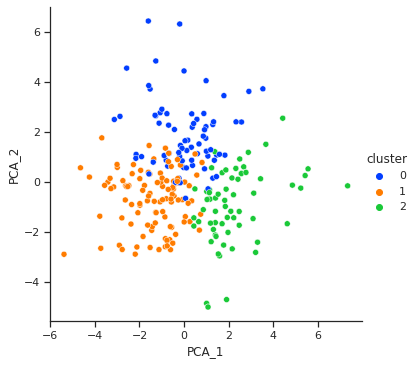

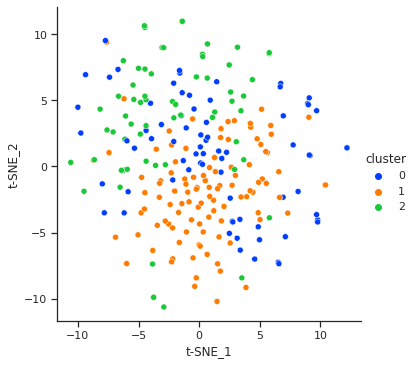

In [ ]:
# PCA :
g = sns.relplot(x="PCA_1", y="PCA_2", hue="cluster", data=song_df, palette=palette )
g.savefig("clusters_PCA_2.eps")

# t-SNE
g = sns.relplot(x="t-SNE_1", y="t-SNE_2", hue="cluster", data=song_df, palette=palette )
g.savefig("clusters_t-SNE_2.eps")

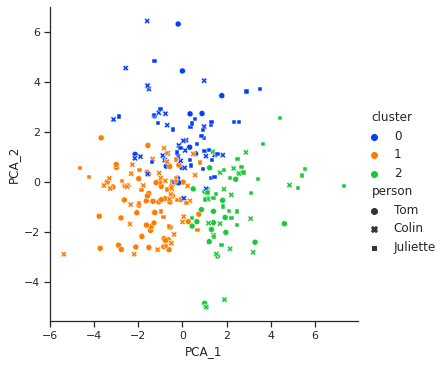

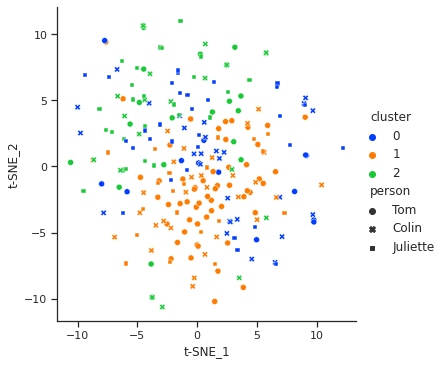

In [ ]:
# compare the cluster with actual partition :
# PCA :
g = sns.relplot(x="PCA_1", y="PCA_2", hue="cluster", style="person", data=song_df, palette=palette )
g.savefig("PCA_and_cluster_distillbert_2.eps")

# t-SNE
g = sns.relplot(x="t-SNE_1", y="t-SNE_2", hue="cluster", style="person", data=song_df, palette=palette )
g.savefig("TSNE_and_cluster_distillbert_2.eps")


**Quality of the clustering**

To asses the quality of the clustering we can use the jaccard similarity function that was build for the second homewrok. This function allow to see the similarity between 2 different clusterings that where made. In this case, the fisrt clustering will be the true one (the actual label for each song) and it will be compared with the clustering made trhough k-mean



### Jaccard similarity

In [ ]:
# Define the function
import itertools 

def jaccard(lab1,lab2,ind1,ind2):
  """
  Computes the Jaccard similarity between two sets of clustering labels and indexes with different sizes.
  The value returned is between 0 and 1, inclusively. A value of 1 indicates
  perfect agreement between two clustering algorithms, whereas a value of 0
  indicates no agreement.
  Example:
  lab1 = ["Amidala","Anakin","Qui_gon","Yoda"]
  lab2 = ["Amidala","Anakin","Qui_gon"]
  ind = [0,0,1,3]
  ind = [0,0,2]
  print jaccard(labels1, labels2, index1, index2)
  @return the Jaccard similarity value
  """
# To take into account the case where the two sets do not compare the same elements (the same characters here),
# we build for each set a new list of characters considering all characters from the two sets.
# For the characters that didn't belong to one set, we assign them a "-1" number of clustering.
# Later, we will ignore the cases where two elements give a positive comparison with two "-1" indexes of clusters.
  dico1 = {}
  dico2 = {}
  for i in range(len(lab1)):
    dico1[lab1[i]] = ind1[i]
  for j in range(len(lab2)):
    dico2[lab2[j]] = ind2[j]
  for i in range(len(lab2)):
    if lab2[i] not in dico1.keys():
      dico1[lab2[i]] = -1
  for j in range(len(lab1)):
    if lab1[j] not in dico2.keys():
      dico2[lab1[j]] = -1
# Redefining a list for the characters' names and for their cluster number : first set
  label1 = list(dico1.keys())
  label1.sort()
  index1 = []
  for name in label1:
    index1.append(dico1[name])
# Redefining a list for the characters' names and for their cluster number : second set
  label2 = list(dico2.keys())
  label2.sort()
  index2 = []
  for name in label2:
    index2.append(dico2[name])

  n = len(label1)
  n11 = n10 = n01 = 0
  for i, j in itertools.combinations(range(n), 2):
    if index1[i] == -1 and index1[j] == -1:
      comembership1 = False
    else:
      comembership1 = (index1[i] == index1[j])
    if index2[i] == -1 and index2[j] == -1:
      comembership2 = False
    else:
      comembership2 = (index2[i] == index2[j])
    if comembership1 and comembership2:
      n11 += 1
    elif comembership1 and not comembership2:
      n10 += 1
    elif not comembership1 and comembership2:
      n01 += 1
# To avoid ZeroDivisionError
  if n11 == 0:
    if n10 == 0 and n01 == 0:
      return 0

  return (float(n11) / (n11 + n10 + n01))

In our case, the "label", in this function, are the name of the musics. Because each music was classified in one cluster. We will thus use the index of the song in the Df as the "label" of of each song (lab1 and lab2). Then the inexes (ind1, ind2) represent the cluster that was assigned to each song. It is thus on one hand the actual label (i.e Tom, Colin and Juliette, labelled as 0,1,2) and on the other hand the column called "cluster" with the results of the k-mean clustering.

In [ ]:
lab1 = song_df.index.to_list()
lab2 = song_df.index.to_list()

ind1 = song_df["label"].to_list()
ind2 = song_df["cluster"].to_list()

song_df.iloc[[0,-1],:]

,embedded_song,label,person,t-SNE_1,t-SNE_2,cluster,PCA_1,PCA_2
0,"[-0.57933867, 0.7780801, 0.10045579, -0.196416...",0,Tom,-0.160955,-1.600326,1,-1.53661,0.311426
242,"[-0.3667807, 0.39418426, 0.0031347198, 0.01646...",2,Juliette,0.337761,-4.950053,1,-4.64604,0.561411


In [ ]:
# Result of the similarity between actual and predicted label : 
print(round(jaccard(lab1,lab2,ind1,ind2),3))

0.223


## Random Forest Classifier



First we create the training and test set

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
train, test = train_test_split(song_df, test_size=0.2)

X_train = list(train['embedded_song'])
y_train = train['label']

X_test = list(test['embedded_song'])
y_test = test['label']

In [ ]:
print("Test",Counter(y_test))
print("Train",Counter(y_train))

### Train the classifier

In [ ]:
# First, initialise and train the classifier on the train sets
classifierRF = RandomForestClassifier(max_depth=5 ,random_state=3)
classifierRF = classifierRF.fit (X_train, y_train)

### Predict

In [ ]:
# PREDICT THE LABELS
y_pred = classifierRF.predict(X_test)
y_train_pred = classifierRF.predict(X_train)

In [ ]:
# SHOW THE ACCURACY SCORE OF CLASSIFICATION
# YOU CAN ALSO USE METRICS LIKE: PRECISION, RECALL, AOC (AREA UNDER THE CURVE)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_pred)
print(f"Accuracy:\n  training :: {round(acc_train,3)*100} %\n  test     :: {round(acc_test,3)*100} %")

Accuracy:
  training :: 99.5 %
  test     :: 40.8 %


Ok that's not so bad but the problem is that this accuracy on the testing set greatly depend on the trainning and testinset that is being chosen because our datset only contain a few songs (35) for each person. 

Could thus create a loop to do this process of classification several tims with different way of fractionning our training and test set and calculate the mean accuracy. 

we can also do it with different parameter of max_depth for the RFC

In [ ]:
list(range(5,35,5))

In [ ]:
n = 15
stdd_acc_train = []
stdd_acc_test = []
mean_acc_train = []
mean_acc_test = []
param = []
md_value = [13] # list(range(1,20,3))
rs_value = list(range(0,5,1))

for rs in rs_value:

  for md in md_value:
    # Define RFC
    classifierRF = RandomForestClassifier(max_depth=md ,random_state=rs) # n_estimators=100

    acc_train = []
    acc_test = []

    for i in range(n):
      # Split the set
      train, test = train_test_split(song_df, test_size=0.2)
      X_train = list(train['embedded_song'])
      y_train = train['label']
      X_test = list(test['embedded_song'])
      y_test = test['label']

      # Training
      classifierRF = classifierRF.fit (X_train, y_train)

      # do the prediction
      y_pred = classifierRF.predict(X_test)
      y_train_pred = classifierRF.predict(X_train)

      # get accuracy
      acc_train.append( accuracy_score(y_train, y_train_pred) )
      acc_test.append(  accuracy_score(y_test, y_pred)        )

    mean_acc_train.append (round(np.mean(acc_train),3)*100)
    mean_acc_test.append (round(np.mean(acc_test),3)*100)
    stdd_acc_train.append(np.std(acc_train))
    stdd_acc_test.append(np.std(acc_test))
    param.append([rs,md])

In [ ]:
print("mean acc")
print(mean_acc_train)
print(mean_acc_test)
print(param)

print(" ")

print("best acc : ", max(mean_acc_test), "best param : " , param[mean_acc_test.index(max(mean_acc_test))])

mean acc
[99.5, 99.3, 99.4, 99.4, 99.3]
[46.7, 49.3, 48.4, 46.9, 46.400000000000006]
[[0, 13], [1, 13], [2, 13], [3, 13], [4, 13]]
 
best acc :  49.3 best param :  [1, 13]


the following numbers show that the mean a lot depending on which parametrs of max_depth we are choosing. the accuracy on the testing set stays around 50%.

But what we can also see is that for one given parameter, the accuracy varies a lot depending on the set of test that was created by the `split` method. And thus it would be important to have a larger set of testing and training.

mean acc \\
[99.3, 99.4, 99.3, 99.2, 99.3, 99.3] \\
[50.2, 50.4, 45.3, 50.0, 47.6, 47.8] \\
[5, 10, 15, 20, 25, 30] \\


acc for one value of dm \\
[46.9, 53.1, 51.0, 61.1, 53.1, 55.1, 53.1, 49.0, 42.9, 40.8] \\
[99.0, 99.0, 99.5, 99.5, 99.5, 99.0, 99.0, 99.5, 99.0, 100.0] \\

best acc :  50.9 best param :  [0, 13] \\

In [ ]:
np.array(stdd_acc_train)*100

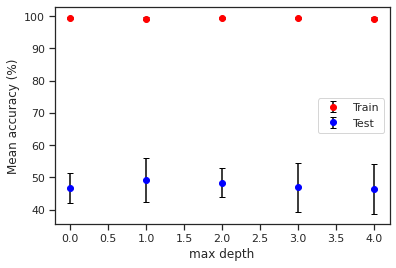

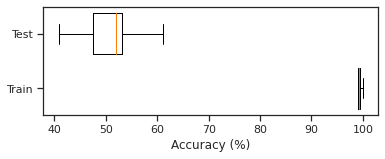

In [ ]:
# 
fig = plt.figure(figsize=(6,4))
plt.errorbar(x=rs_value, y=mean_acc_train, yerr=np.array(stdd_acc_train)*100, ecolor="black",
             color = 'red', label='Train', linestyle='None', fmt='o', capsize=3)
plt.errorbar(x=rs_value, y=mean_acc_test, yerr=np.array(stdd_acc_test)*100, ecolor="black",
            color = 'blue', label='Test', linestyle='None', fmt='o', capsize=3)
plt.xlabel("max depth")
plt.ylabel("Mean accuracy (%)")
plt.legend()
plt.savefig("accuracy_max_depth.eps")
plt.show()

# acc for one value of dm 
test = [46.9, 53.1, 51.0, 61.1, 53.1, 55.1, 53.1, 49.0, 42.9, 40.8] 
train = [99.0, 99.0, 99.5, 99.5, 99.5, 99.0, 99.0, 99.5, 99.0, 100.0]

fig = plt.figure(figsize=(6,2) )
plt.boxplot(train, vert=False, positions=[1], widths=0.75)
plt.boxplot(test, vert=False,positions=[2], widths=0.75)
plt.yticks([1,2],["Train", "Test"])
plt.xlabel("Accuracy (%)")
plt.savefig("accuracy_train_test.eps")
plt.show()


## Predictions of best appreciations

# Comparing the 2 different approaches

## Lyrics based prediction

In [ ]:
c = test_songs[:4]
j = [test_songs[4]]
t = test_songs[5:10]

In [ ]:
encoded_c = encode_songs(cleanner(clean_sentence(c)))
encoded_j = encode_songs(cleanner(clean_sentence(j)))
encoded_t = encode_songs(cleanner(clean_sentence(t)))

In [ ]:
print(len(encoded_c), len(encoded_t), len(encoded_j))
type(encoded_t)

In [ ]:
td = pd.DataFrame({'embedded_song':encoded_t,
                  'person' : 'Tom' })
cd = pd.DataFrame({'embedded_song':encoded_c,
                  'person' : 'Colin' })
jd = pd.DataFrame({'embedded_song':encoded_j,
                  'person' : 'Juliette' })

test_df = pd.concat([cd,jd,td], ignore_index=True)
test_df

In [ ]:
# train RFC on all training set
X_train = list(song_df['embedded_song'])
y_train = song_df['person']

classifierRF = RandomForestClassifier(max_depth=20 ,random_state=0)
classifierRF = classifierRF.fit (X_train, y_train)

X_test = test_df["embedded_song"].to_list()
y_test = test_df["person"]

In [ ]:
# PREDICT THE LABELS
y_pred = classifierRF.predict(X_test)
y_train_pred = classifierRF.predict(X_train)

In [ ]:
# SHOW THE ACCURACY SCORE OF CLASSIFICATION
# YOU CAN ALSO USE METRICS LIKE: PRECISION, RECALL, AOC (AREA UNDER THE CURVE)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_pred)
print(f"Accuracy:\n  training :: {round(acc_train,3)*100} %\n  test     :: {round(acc_test,3)*100} %")

In [ ]:
row = [1,2,3,4,5,6]
print(test_df.loc[row,:])
print(classifierRF.predict(list(test_df.loc[row,"embedded_song"])))

In [ ]:
label = ['Colin','Colin', 'Colin','Colin', 'Juliette','Tom', 'Tom', 'Tom', 'Tom', 'Tom']

In [ ]:
for i in range(10):
  print("Lyrics to be predicted :",test_songs[i],"\n")
  encode = encode_songs(cleanner(clean_sentence([test_songs[i]])))
  print("Embeddings of the lyrics : \n", encode[0][:12],"\n")
  print("Belief :  ", label[i])
  print("Prediction for each embeddings : ", classifierRF.predict(encode))
  print("___________________________________________________________________________ \n")

# Merry Christmas

In [6]:
import time
for i in range(2,40,2):
  print("{:^40}".format("*" * i))
  time.sleep(0.2)
for _ in range(5):
  print("{:^40}".format("**"))

print("           !!!  Joyeux Noel !!! ")

                   **                   
                  ****                  
                 ******                 
                ********                
               **********               
              ************              
             **************             
            ****************            
           ******************           
          ********************          
         **********************         
        ************************        
       **************************       
      ****************************      
     ******************************     
    ********************************    
   **********************************   
  ************************************  
 ************************************** 
                   **                   
                   **                   
                   **                   
                   **                   
                   **                   
           !!!  